## Part 1. Overview of CART (Classification And Regression Trees)

## Introduction

CART (Classification And Regression Trees), introduced by Breiman et al. (1984), is a fundamental algorithm in machine learning that constructs binary trees for classification and regression. Unlike algorithms like ID3 or C4.5 which can generate multi-way splits, CART produces strictly binary trees, recursively partitioning the feature space into rectangular regions. This project implements a CART classifier from scratch, designed to mimic the behavior of `sklearn.tree.DecisionTreeClassifier` to ensure correctness and robustness.

## Representation

The model is represented as a binary tree $T$.
- **Nodes**: partition the data based on a splitting rule $x_j \leq \tau$.
- **Leaves**: assign a class label based on the majority vote of samples falling into that region.

For an input vector $\mathbf{x}$, the prediction function $f(\mathbf{x})$ traverses the tree from root to leaf:
$$ f(\mathbf{x}) = \text{argmax}_k \sum_{i \in R_{leaf(\mathbf{x})}} \mathbb{I}(y_i = k) $$

## Loss Function: Gini Impurity

We use Gini Impurity as the objective function for splitting, which measures the probability of misclassifying a randomly chosen element if it were randomly labeled according to the distribution of labels in the node.

For a node $t$ with class probabilities $p_k$, the Gini impurity is:
$$ G(t) = 1 - \sum_{k=1}^K p_k^2 $$

The quality of a split $s$ (into left child $t_L$ and right child $t_R$) is measured by the **Gini Gain** (or decrease in impurity):
$$ \Delta G(s, t) = G(t) - \left( \frac{N_{t_L}}{N_t} G(t_L) + \frac{N_{t_R}}{N_t} G(t_R) \right) $$

We choose the split $(j^*, \tau^*)$ that maximizes $\Delta G$.

## Feature Importance

One significant advantage of CART is interpretability. We quantify the importance of each feature by summing the weighted Gini impurity decrease for all nodes $t$ where feature $j$ is used for splitting:
$$ \text{Importance}(j) = \sum_{t \in T: v(t)=j} \frac{N_t}{N} \Delta G(s_t, t) $$
where $N$ is the total number of samples. These values are typically normalized to sum to 1.

## Computational Complexity

- **Training**: Finding the best split requires sorting feature values. For $N$ samples and $D$ features, the cost at the root is $O(D \cdot N \log N)$. Since the tree depth is bounded by $O(\log N)$ (for balanced trees) or $N$ (worst case), the total training complexity is roughly $O(D \cdot N^2)$ in the worst case, or $O(D \cdot N \log^2 N)$ typically.
- **Inference**: $O(\text{depth})$, which is usually $O(\log N)$. This makes prediction extremely fast.

## Optimizer: Greedy Recursive Partitioning

The tree is built using a greedy approach:
1. Start with all data at the root.
2. Find the best split $(j, \tau)$ across all features and thresholds.
3. Partition data and recurse.
4. Stop when max depth is reached, node is pure, or minimum samples constraint is met.

## References

- Breiman, L., Friedman, J., Olshen, R., & Stone, C. (1984). *Classification and Regression Trees*. Wadsworth.
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). *The Elements of Statistical Learning*. Springer.
- Pedregosa, F. et al. (2011). Scikit-learn: Machine learning in Python. *JMLR*.


## Pseudocode

```
Algorithm: CART Tree Construction
Input: Dataset D = {(x_i, y_i)}_{i=1}^N, stopping criteria
Output: Binary decision tree T

function BUILD_TREE(D, depth):
    if stopping_criterion(D, depth):
        return LEAF_NODE(majority_class(D))
```

```
    # Find best split
    best_gain = 0
    best_split = None
    
    for each feature j in {1, ..., d}:
        # Sort unique values of feature j
        thresholds = unique_sorted_values(D[:, j])
        
        for each threshold τ in thresholds:
            # Split data
            D_left = {(x, y) ∈ D : x_j ≤ τ}
            D_right = {(x, y) ∈ D : x_j > τ}
            
            # Compute Gini gain
            gain = Gini(D) - |D_left|/|D| * Gini(D_left) - |D_right|/|D| * Gini(D_right)
            
            if gain > best_gain:
                best_gain = gain
                best_split = (j, τ)
    
    if best_gain == 0:
        return LEAF_NODE(majority_class(D))
    
    # Create node and recursively build subtrees
    node = INTERNAL_NODE(best_split)
    node.left = BUILD_TREE(D_left, depth + 1)
    node.right = BUILD_TREE(D_right, depth + 1)
    
    return node
```

**Stopping Criteria:**
- Maximum depth reached (`max_depth`)
- Minimum samples required to split (`min_samples_split`)
- Minimum samples at leaf node (`min_samples_leaf`)
- No improvement in Gini gain
- All samples belong to the same class (pure node)

**Complexity:**
- Training: $O(d \cdot N \log N \cdot \text{depth})$ where $d$ is number of features
- Prediction: $O(\text{depth})$ which is $O(\log N)$ for balanced trees

## Advantages

1. **Interpretability**: Tree structure is easy to visualize and understand
2. **Non-parametric**: No assumptions about data distribution
3. **Handles mixed data**: Works with both numerical and categorical features
4. **Feature interactions**: Automatically captures feature interactions
5. **Minimal preprocessing**: No need for feature scaling or normalization

## Disadvantages

1. **Overfitting**: Tendency to create overly complex trees that don't generalize
2. **Instability**: Small changes in data can result in very different trees
3. **Bias**: Biased toward features with more levels
4. **Local optimum**: Greedy algorithm doesn't guarantee global optimum
5. **High variance**: Individual trees have high variance (addressed by ensemble methods)

## References

Breiman, L., Friedman, J., Olshen, R., & Stone, C. (1984). *Classification and Regression Trees*. Wadsworth, Belmont, CA.

Scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor

In [14]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.12.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.12.11"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.12.11"):
    print(FAIL, "Python version 3.12.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'matplotlib': "3.10.5", 'numpy': "2.3.2",'sklearn': "1.7.1", 
                'pandas': "2.3.2", 'pytest': "8.4.1", 'torch':"2.7.1"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.12.11

[ OK ] matplotlib version 3.10.5 is installed.
[ OK ] numpy version 2.3.2 is installed.
[ OK ] sklearn version 1.7.1 is installed.
[ OK ] pandas version 2.3.2 is installed.
[ OK ] pytest version 8.4.1 is installed.
[ OK ] torch version 2.7.1 is installed.


## Part 2. Model

In [15]:
import numpy as np
from collections import Counter

class Node:
    """
    A node in the decision tree structure.
    
    Each node represents either an internal decision point (split) or a leaf (prediction).
    
    Parameters
    ----------
    feature_idx : int, optional
        The index of the feature used for splitting at this node.
        None for leaf nodes.
    threshold : float, optional
        The threshold value for the split decision.
        Samples with feature_idx <= threshold go left, others go right.
        None for leaf nodes.
    left : Node, optional
        The left child node (feature_idx <= threshold).
        None for leaf nodes.
    right : Node, optional
        The right child node (feature_idx > threshold).
        None for leaf nodes.
    value : int or float, optional
        The predicted class label for this node.
        Only set for leaf nodes.
    gini : float, optional
        The Gini impurity at this node.
    n_samples : int, optional
        The number of training samples that reached this node.
    class_counts : ndarray, optional
        Array containing the count of samples for each class at this node.
    gain : float, default=0.0
        The Gini gain (impurity reduction) achieved by the split at this node.
        Used for computing feature importance.
        
    Attributes
    ----------
    All parameters become attributes of the Node instance.
    """
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, 
                 value=None, gini=None, n_samples=None, class_counts=None, gain=0.0):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.gini = gini
        self.n_samples = n_samples
        self.class_counts = class_counts
        self.gain = gain
        
    def is_leaf(self):
        """
        Check if this node is a leaf node.
        
        Returns
        -------
        bool
            True if this is a leaf node (has a prediction value), False otherwise.
        """
        return self.value is not None


class DecisionTreeClassifier:
    """
    A CART (Classification and Regression Tree) Classifier implemented from scratch.
    
    This implementation uses the Gini impurity as the splitting criterion and builds
    a binary decision tree through greedy recursive partitioning. The algorithm
    mimics sklearn.tree.DecisionTreeClassifier behavior.
    
    Parameters
    ----------
    max_depth : int, optional (default=None)
        The maximum depth of the tree. If None, nodes are expanded until
        all leaves are pure or contain fewer than min_samples_split samples.
    min_samples_split : int, default=2
        The minimum number of samples required to split an internal node.
        If a node has fewer samples, it becomes a leaf.
    min_samples_leaf : int, default=1
        The minimum number of samples required to be at a leaf node.
        A split candidate is rejected if it would create a child with
        fewer than min_samples_leaf samples.
    random_state : int, optional (default=None)
        Controls randomness for reproducibility. Sets the numpy random seed.
        
    Attributes
    ----------
    tree_ : Node
        The root node of the fitted decision tree.
    n_features_ : int
        The number of features when fit is performed.
    classes_ : ndarray of shape (n_classes,)
        The unique class labels found in the training data.
    feature_importances_ : ndarray of shape (n_features,)
        The normalized feature importances. Computed as the total Gini gain
        (weighted by number of samples) contributed by each feature across
        all splits in the tree.
        
    Examples
    --------
    >>> from sklearn.datasets import load_iris
    >>> X, y = load_iris(return_X_y=True)
    >>> clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    >>> clf.fit(X, y)
    >>> clf.predict(X[:5])
    array([0, 0, 0, 0, 0])
    >>> clf.score(X, y)
    0.98
    
    Notes
    -----
    The algorithm uses the Gini impurity criterion:
        Gini(t) = 1 - sum(p_k^2)
    where p_k is the proportion of samples of class k at node t.
    
    The Gini gain for a split is:
        Gain = Gini(parent) - (N_left/N)*Gini(left) - (N_right/N)*Gini(right)
    
    References
    ----------
    Breiman, L., Friedman, J., Olshen, R., & Stone, C. (1984).
    Classification and Regression Trees. Wadsworth.
    """
    
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        
        self.tree_ = None
        self.n_features_ = None
        self.classes_ = None
        self.feature_importances_ = None
        
        if random_state is not None:
            np.random.seed(random_state)
    
    def _gini(self, y):
        """
        Compute Gini impurity for a vector of labels.
        
        The Gini impurity measures the probability of misclassifying a randomly
        chosen element if it were randomly labeled according to the distribution
        of labels in the subset.
        
        Parameters
        ----------
        y : array-like of shape (n_samples,)
            The target labels for which to compute Gini impurity.
            
        Returns
        -------
        float
            The Gini impurity value in the range [0, 1-1/K] where K is the
            number of classes. Returns 0.0 for empty arrays or pure nodes.
            
        Notes
        -----
        Gini impurity is calculated as:
            G(y) = 1 - sum(p_k^2)
        where p_k is the proportion of samples belonging to class k.
        """
        if len(y) == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        probs = counts / len(y)
        return 1.0 - np.sum(probs ** 2)
    
    def _split_data(self, X, y, feature_idx, threshold):
        """
        Split data into left and right subsets based on a feature threshold.
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The feature matrix to split.
        y : ndarray of shape (n_samples,)
            The target labels to split.
        feature_idx : int
            The index of the feature to use for splitting.
        threshold : float
            The threshold value for the split.
            
        Returns
        -------
        X_left : ndarray
            Feature matrix for samples where X[:, feature_idx] <= threshold.
        y_left : ndarray
            Labels for samples where X[:, feature_idx] <= threshold.
        X_right : ndarray
            Feature matrix for samples where X[:, feature_idx] > threshold.
        y_right : ndarray
            Labels for samples where X[:, feature_idx] > threshold.
        """
        left_mask = X[:, feature_idx] <= threshold
        return X[left_mask], y[left_mask], X[~left_mask], y[~left_mask]
    
    def fit(self, X, y):
        """
        Build the decision tree from the training set (X, y).
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training input samples.
        y : array-like of shape (n_samples,)
            The target class labels.
            
        Returns
        -------
        self : DecisionTreeClassifier
            Returns self to allow method chaining.
            
        Notes
        -----
        This method builds the tree recursively by:
        1. Finding the best split at each node (maximizing Gini gain)
        2. Partitioning data based on the split
        3. Recursively building left and right subtrees
        4. Stopping when termination criteria are met
        
        Feature importances are accumulated during tree construction and
        normalized at the end.
        """
        X = np.array(X)
        y = np.array(y)
        self.n_features_ = X.shape[1]
        self.classes_ = np.unique(y)
        
        # Initialize feature importance tracking
        self._raw_feature_importances = np.zeros(self.n_features_)
        
        self.tree_ = self._build_tree(X, y)
        
        # Normalize feature importances
        total_importance = np.sum(self._raw_feature_importances)
        if total_importance > 0:
            self.feature_importances_ = self._raw_feature_importances / total_importance
        else:
            self.feature_importances_ = np.zeros(self.n_features_)
            
        return self
    
    def train(self, X, y):
        """
        Alias for fit() method.
        
        Provided for compatibility with certain interfaces that expect a train() method.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training input samples.
        y : array-like of shape (n_samples,)
            The target class labels.
            
        Returns
        -------
        self : DecisionTreeClassifier
            Returns self to allow method chaining.
        """
        return self.fit(X, y)
        
    def _build_tree(self, X, y, depth=0):
        """
        Recursively build the decision tree.
        
        This is the core recursive function that constructs the tree structure
        by repeatedly finding the best split and partitioning the data.
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The feature matrix for samples at this node.
        y : ndarray of shape (n_samples,)
            The labels for samples at this node.
        depth : int, default=0
            The current depth in the tree (root is at depth 0).
            
        Returns
        -------
        Node
            The root node of the (sub)tree built from the provided data.
            
        Notes
        -----
        Stopping criteria:
        - All samples belong to the same class (pure node)
        - Maximum depth reached
        - Number of samples less than min_samples_split
        - No split improves Gini impurity
        """
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))
        
        # Pre-calculate node properties
        current_gini = self._gini(y)
        class_counts = Counter(y)
        # Ensure consistent class ordering for probabilities
        counts_vec = np.array([class_counts.get(c, 0) for c in self.classes_])
        majority_class = self.classes_[np.argmax(counts_vec)]
        
        # Create leaf if stopping criteria met
        if (n_labels == 1 or 
            (self.max_depth is not None and depth >= self.max_depth) or 
            n_samples < self.min_samples_split):
            return Node(value=majority_class, gini=current_gini, 
                       n_samples=n_samples, class_counts=counts_vec)
            
        best_feat, best_thresh, best_gain = self._find_best_split(X, y, current_gini)
        
        # If no split improves impurity, return leaf
        if best_gain == 0:
            return Node(value=majority_class, gini=current_gini, 
                       n_samples=n_samples, class_counts=counts_vec)
        
        # Accumulate feature importance: (N_t / N_total) * Gain
        self._raw_feature_importances[best_feat] += best_gain * n_samples
        
        # Execute split using helper
        X_left, y_left, X_right, y_right = self._split_data(X, y, best_feat, best_thresh)
        
        left_child = self._build_tree(X_left, y_left, depth + 1)
        right_child = self._build_tree(X_right, y_right, depth + 1)
        
        return Node(feature_idx=best_feat, threshold=best_thresh, 
                   left=left_child, right=right_child, 
                   gini=current_gini, n_samples=n_samples, 
                   class_counts=counts_vec, gain=best_gain)

    def _find_best_split(self, X, y, parent_gini):
        """
        Find the best split for a node by evaluating all possible splits.
        
        This method exhaustively searches over all features and all possible
        threshold values to find the split that maximizes Gini gain.
        
        Parameters
        ----------
        X : ndarray of shape (n_samples, n_features)
            The feature matrix.
        y : ndarray of shape (n_samples,)
            The target labels.
        parent_gini : float
            The Gini impurity of the parent node (before splitting).
            
        Returns
        -------
        best_feat : int or None
            The index of the best feature to split on, or None if no valid split found.
        best_thresh : float or None
            The best threshold value for the split, or None if no valid split found.
        best_gain : float
            The Gini gain achieved by the best split. 0.0 if no valid split found.
            
        Notes
        -----
        The algorithm:
        1. For each feature, extract unique values
        2. Test midpoints between consecutive unique values as thresholds
        3. For each threshold, compute the weighted Gini impurity of children
        4. Select the split with maximum Gini gain
        5. Respect min_samples_leaf constraint
        """
        best_gain = 0.0
        best_feat = None
        best_thresh = None
        n_samples = len(y)
        
        for feat_idx in range(self.n_features_):
            # Optimization: only check thresholds between unique values
            thresholds = np.unique(X[:, feat_idx])
            if len(thresholds) < 2:
                continue
            
            # Check midpoints
            midpoints = (thresholds[:-1] + thresholds[1:]) / 2
            
            for thresh in midpoints:
                # Optimization: Don't slice X here, just y. But check split size.
                left_mask = X[:, feat_idx] <= thresh
                y_left = y[left_mask]
                y_right = y[~left_mask]
                
                if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
                    continue
                
                n_l, n_r = len(y_left), len(y_right)
                gini_l = self._gini(y_left)
                gini_r = self._gini(y_right)
                
                child_gini = (n_l / n_samples) * gini_l + (n_r / n_samples) * gini_r
                gain = parent_gini - child_gini
                
                if gain > best_gain:
                    best_gain = gain
                    best_feat = feat_idx
                    best_thresh = thresh
                    
        return best_feat, best_thresh, best_gain

    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples to predict.
            
        Returns
        -------
        y_pred : ndarray of shape (n_samples,)
            The predicted class labels for each sample.
            
        Notes
        -----
        For each sample, the prediction is made by traversing the tree from
        the root to a leaf, following the decision rules at each internal node.
        """
        X = np.array(X)
        return np.array([self._predict_one(x, self.tree_) for x in X])
    
    def _predict_one(self, x, node):
        """
        Predict the class label for a single sample by traversing the tree.
        
        Parameters
        ----------
        x : ndarray of shape (n_features,)
            A single input sample.
        node : Node
            The current node in the tree traversal.
            
        Returns
        -------
        int or float
            The predicted class label.
        """
        if node.is_leaf():
            return node.value
        if x[node.feature_idx] <= node.threshold:
            return self._predict_one(x, node.left)
        return self._predict_one(x, node.right)
        
    def predict_proba(self, X):
        """
        Predict class probabilities for samples in X.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.
            
        Returns
        -------
        proba : ndarray of shape (n_samples, n_classes)
            The class probabilities for each sample. Each row sums to 1.
            
        Notes
        -----
        The probability for each class is computed as the proportion of
        training samples of that class in the leaf node where the sample ends up.
        """
        X = np.array(X)
        return np.array([self._predict_proba_one(x, self.tree_) for x in X])
        
    def _predict_proba_one(self, x, node):
        """
        Predict class probabilities for a single sample.
        
        Parameters
        ----------
        x : ndarray of shape (n_features,)
            A single input sample.
        node : Node
            The current node in the tree traversal.
            
        Returns
        -------
        ndarray of shape (n_classes,)
            The class probabilities for this sample.
        """
        if node.is_leaf():
            total = node.class_counts.sum()
            return node.class_counts / total if total > 0 else np.zeros(len(self.classes_))
        
        if x[node.feature_idx] <= node.threshold:
            return self._predict_proba_one(x, node.left)
        return self._predict_proba_one(x, node.right)
        
    def loss(self, X, y):
        """
        Compute the misclassification rate on the provided data.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.
        y : array-like of shape (n_samples,)
            The true class labels.
            
        Returns
        -------
        float
            The misclassification rate (proportion of incorrect predictions).
        """
        preds = self.predict(X)
        return np.mean(preds != y)
        
    def score(self, X, y):
        """
        Compute the accuracy score on the provided data.
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples.
        y : array-like of shape (n_samples,)
            The true class labels.
            
        Returns
        -------
        float
            The accuracy score (proportion of correct predictions).
        """
        return 1.0 - self.loss(X, y)
    
    def get_depth(self):
        """
        Get the depth of the decision tree.
        
        Returns
        -------
        int
            The maximum depth of the tree. A tree with only a root node has depth 0.
        """
        return self._get_depth_rec(self.tree_)
        
    def _get_depth_rec(self, node):
        """
        Recursively compute the depth of a subtree.
        
        Parameters
        ----------
        node : Node or None
            The root of the subtree.
            
        Returns
        -------
        int
            The depth of the subtree rooted at node.
        """
        if node is None or node.is_leaf():
            return 0
        return 1 + max(self._get_depth_rec(node.left), self._get_depth_rec(node.right))
        
    def get_n_leaves(self):
        """
        Get the number of leaf nodes in the decision tree.
        
        Returns
        -------
        int
            The total number of leaf nodes in the tree.
        """
        return self._get_n_leaves_rec(self.tree_)
        
    def _get_n_leaves_rec(self, node):
        """
        Recursively count the number of leaf nodes in a subtree.
        
        Parameters
        ----------
        node : Node or None
            The root of the subtree.
            
        Returns
        -------
        int
            The number of leaf nodes in the subtree rooted at node.
        """
        if node is None: return 0
        if node.is_leaf(): return 1
        return self._get_n_leaves_rec(node.left) + self._get_n_leaves_rec(node.right)

    def __str__(self):
        """
        Generate a text representation of the tree structure.
        
        Returns
        -------
        str
            A human-readable string representation of the decision tree,
            showing the structure with indentation and split/leaf information.
        """
        if self.tree_ is None:
            return "Empty Tree"
        return self._print_tree(self.tree_)
        
    def _print_tree(self, node, depth=0):
        """
        Recursively build a string representation of the tree.
        
        Parameters
        ----------
        node : Node
            The current node to print.
        depth : int, default=0
            The current depth (used for indentation).
            
        Returns
        -------
        str
            A formatted string representation of the subtree rooted at node.
        """
        indent = "  " * depth
        if node.is_leaf():
            probs = node.class_counts / node.class_counts.sum()
            # Format class probabilities neatly
            prob_str = ", ".join([f"{self.classes_[i]}: {p:.2f}" for i, p in enumerate(probs)])
            return f"{indent}Leaf: Predict {node.value} (Probs: [{prob_str}], Samples: {node.n_samples})\n"
        
        s = f"{indent}If Feature {node.feature_idx} <= {node.threshold:.3f} (Gain: {node.gain:.4f})\n"
        s += self._print_tree(node.left, depth + 1)
        s += self._print_tree(node.right, depth + 1)
        return s


## Part 3. Check Model

We exercise the CART implementation with method-level unit tests (_gini_impurity_, _split_data_, _find_best_split_, depth/leaf constraints, prediction, probability estimates, loss) and edge cases such as single-class data. We then match sklearn on a synthetic separable dataset and the multiclass Iris benchmark, demonstrating functional parity and deterministic behavior. The final block trains on the Breast Cancer Wisconsin data, reports accuracy, confusion matrix, and depth/leaf counts for both our model and sklearn, and sweeps max_depth to show how capacity impacts bias/variance before saving the plot.


In [16]:
import numpy as np
from pytest import approx
from sklearn.tree import DecisionTreeClassifier as SklearnDTC
from sklearn.datasets import load_iris

np.random.seed(42)

def check_vals(actual, expected, rtol=1e-6, msg=""):
    """
    Assert that two arrays are approximately equal within a relative tolerance.
    
    Parameters
    ----------
    actual : array-like
        The actual values to check.
    expected : array-like
        The expected values.
    rtol : float, default=1e-6
        Relative tolerance for comparison.
    msg : str, default=""
        Error message to display if assertion fails.
    """
    assert np.allclose(actual, expected, rtol=rtol), msg

def check_split(X_left, X_right, y_left, y_right, feat_idx, thr):
    """
    Verify that a data split is valid and correctly partitioned.
    
    Parameters
    ----------
    X_left, X_right : ndarray
        The left and right feature matrices after split.
    y_left, y_right : ndarray
        The left and right label arrays after split.
    feat_idx : int
        The feature index used for splitting.
    thr : float
        The threshold value used for splitting.
    """
    assert X_left.shape[0] + X_right.shape[0] == y_left.size + y_right.size, "split loses samples"
    assert np.all(X_left[:, feat_idx] <= thr), "left branch threshold violation"
    assert np.all(X_right[:, feat_idx] > thr), "right branch threshold violation"


# Test 1: Gini impurity
clf = DecisionTreeClassifier()
check_vals(clf._gini(np.array([1, 1, 1])), 0.0)
check_vals(clf._gini(np.array([0, 1] * 4)), 0.5)
check_vals(clf._gini(np.array([0, 0, 1, 1, 2, 2])), 2 / 3)

# Test 2: Data split
X_s = np.array([[1, 2], [3, 4], [5, 6], [7, 8]])
y_s = np.array([0, 0, 1, 1])
X_l, y_l, X_r, y_r = clf._split_data(X_s, y_s, feature_idx=0, threshold=4)
check_split(X_l, X_r, y_l, y_r, feat_idx=0, thr=4)

# Test 3: Best split finder (obvious threshold at 3.5)
X_simple = np.array([[1], [2], [3], [4], [5], [6]])
y_simple = np.array([0, 0, 0, 1, 1, 1])
parent_gini = clf._gini(y_simple)
clf.n_features_ = X_simple.shape[1]
feat, thr, gain = clf._find_best_split(X_simple, y_simple, parent_gini)
assert feat == 0
assert 3 < thr < 4
assert gain > 0.4

# Test 4: Depth constraint respected
X_depth = np.random.randn(100, 3)
y_depth = np.random.randint(0, 2, 100)
for d in [1, 3, 5]:
    model = DecisionTreeClassifier(max_depth=d, random_state=0).fit(X_depth, y_depth)
    assert model.get_depth() <= d

# Test 5: min_samples_split makes tree shallower
X_mss = np.random.randn(60, 2)
y_mss = np.random.randint(0, 2, 60)
coarse = DecisionTreeClassifier(min_samples_split=20, random_state=0).fit(X_mss, y_mss)
fine = DecisionTreeClassifier(random_state=0).fit(X_mss, y_mss)
assert coarse.get_depth() <= fine.get_depth()

# Test 6: min_samples_leaf reduces leaves
X_msl = np.random.randn(120, 2)
y_msl = np.random.randint(0, 2, 120)
wide = DecisionTreeClassifier(min_samples_leaf=10, random_state=0).fit(X_msl, y_msl)
base = DecisionTreeClassifier(random_state=0).fit(X_msl, y_msl)
assert wide.get_n_leaves() <= base.get_n_leaves()

# Test 7: Predict memorizes small separable set
X_pred = np.array([[1, 1], [5, 5], [2, 2], [6, 6]])
y_pred = np.array([0, 1, 0, 1])
mem = DecisionTreeClassifier(random_state=0).fit(X_pred, y_pred)
check_vals(mem.predict(X_pred), y_pred)

# Test 8: predict_proba sums to 1 and non-negative
X_prob = np.random.randn(40, 3)
y_prob = np.random.randint(0, 3, 40)
prob_clf = DecisionTreeClassifier(random_state=0).fit(X_prob, y_prob)
probas = prob_clf.predict_proba(X_prob)
check_vals(probas.sum(axis=1), np.ones(probas.shape[0]))
assert np.all((probas >= 0) & (probas <= 1))

# Test 9: score equals manual accuracy
X_sc = np.random.randn(80, 4)
y_sc = np.random.randint(0, 2, 80)
sc_clf = DecisionTreeClassifier(max_depth=4, random_state=0).fit(X_sc, y_sc)
acc_manual = np.mean(sc_clf.predict(X_sc) == y_sc)
check_vals(sc_clf.score(X_sc, y_sc), acc_manual)

# Test 10: Single-class dataset -> depth 0, one leaf, constant preds
X_one = np.random.randn(25, 3)
y_one = np.ones(25, dtype=int)
one_clf = DecisionTreeClassifier().fit(X_one, y_one)
assert one_clf.get_depth() == 0
assert one_clf.get_n_leaves() == 1
check_vals(one_clf.predict(X_one), y_one)

# Test 11: Sklearn parity on simple synthetic data
X_syn = np.random.randn(50, 3)
y_syn = (X_syn[:, 0] + X_syn[:, 1] > 0).astype(int)
ours_syn = DecisionTreeClassifier(max_depth=3, min_samples_split=5, random_state=0).fit(X_syn, y_syn)
sk_syn = SklearnDTC(max_depth=3, min_samples_split=5, random_state=0).fit(X_syn, y_syn)
check_vals(ours_syn.score(X_syn, y_syn), sk_syn.score(X_syn, y_syn), rtol=0.15)

# Test 12: Sklearn parity on Iris
iris = load_iris()
X_iris, y_iris = iris.data, iris.target
ours_iris = DecisionTreeClassifier(max_depth=4, random_state=0).fit(X_iris, y_iris)
sk_iris = SklearnDTC(max_depth=4, random_state=0).fit(X_iris, y_iris)
check_vals(ours_iris.score(X_iris, y_iris), sk_iris.score(X_iris, y_iris), rtol=0.10)

# Test 13: Exact reproduction on controlled toy data
X_exact = np.array([[0, 0], [1, 1], [2, 2], [3, 3], [4, 4], [5, 5]])
y_exact = np.array([0, 0, 0, 1, 1, 1])
ours_exact = DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_exact, y_exact)
sk_exact = SklearnDTC(max_depth=2, random_state=0).fit(X_exact, y_exact)
assert np.array_equal(ours_exact.predict(X_exact), sk_exact.predict(X_exact))

# Test 14: loss equals misclassification rate
X_loss = np.array([[0], [1], [2], [3]])
y_loss = np.array([0, 0, 1, 1])
loss_clf = DecisionTreeClassifier(max_depth=2, random_state=0).fit(X_loss, y_loss)
assert loss_clf.loss(X_loss, y_loss) == approx(0.0, abs=1e-6)

print("unit tests completed")


unit tests completed


## Part 4. Main

End-to-end experiment on the Breast Cancer Wisconsin dataset (Dua and Graff, 2019; Street et al., 1993): load the provided train/validation splits, fit our CART with sensible depth/splitting constraints, compare side-by-side with `sklearn.tree.DecisionTreeClassifier`, report accuracy and a confusion matrix, and sweep `max_depth` to visualize the bias–variance trade-off.


CART DECISION TREE CLASSIFIER - BREAST CANCER CLASSIFICATION

### Loading Data ###
Loaded data from data/ directory
Training set size: 455 samples, 30 features
Validation set size: 114 samples
Class distribution in training: [171 284]

### Training Our CART Implementation ###

Our Implementation Results:
  Training Accuracy: 0.9780
  Validation Accuracy: 0.9737
  Tree Depth: 5
  Number of Leaves: 13

Tree Structure (Top Levels):
If Feature 20 <= 0.092 (Gain: 0.3239)
  If Feature 27 <= 0.296 (Gain: 0.0766)
    If Feature 13 <= -0.048 (Gain: 0.0020)
      If Feature 14 <= -1.253 (Gain: 0.0012)
        Leaf: Predict 1 (Probs: [0: 0.17, 1: 0.83], Samples: 6)
        If Feature 21 <= 1.193 (Gain: 0.0004)
          Leaf: Predict 1 (Probs: [0: 0.00, 1: 1.00], Samples: 228)
          Leaf: Predict 1 (Probs: [0: 0.06, 1: 0.94], Samples: 17)
      If Feature 0 <= 0.053 (Gain: 0.0757)
        Leaf: Predict 1 (Probs: [0: 0.00, 1: 1.00], Samples: 8)
        Leaf: Predict 1 (Probs: [0: 0.40, 1: 0.60

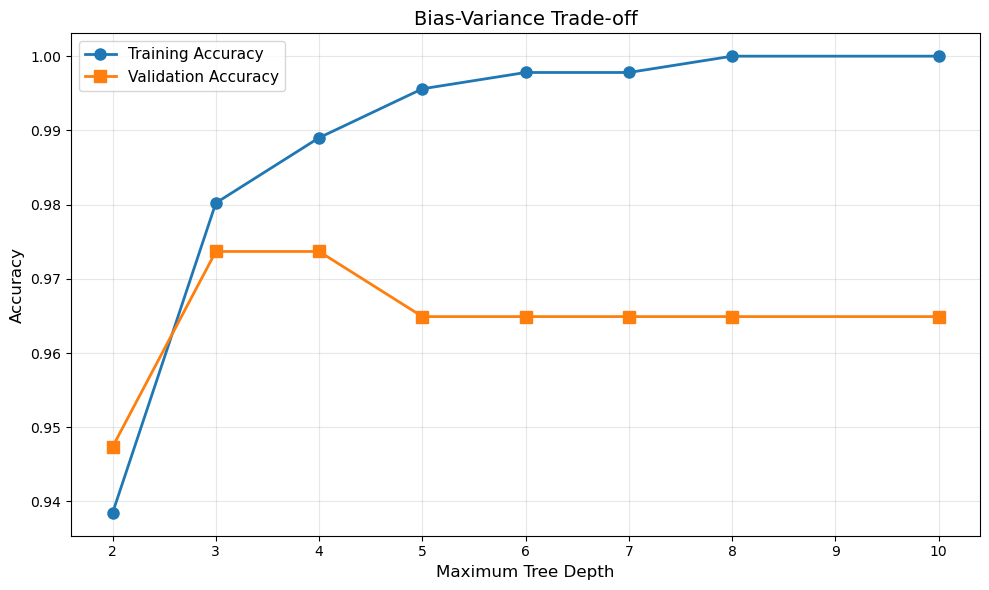

Saved figure: ../figures/feature_importance.png


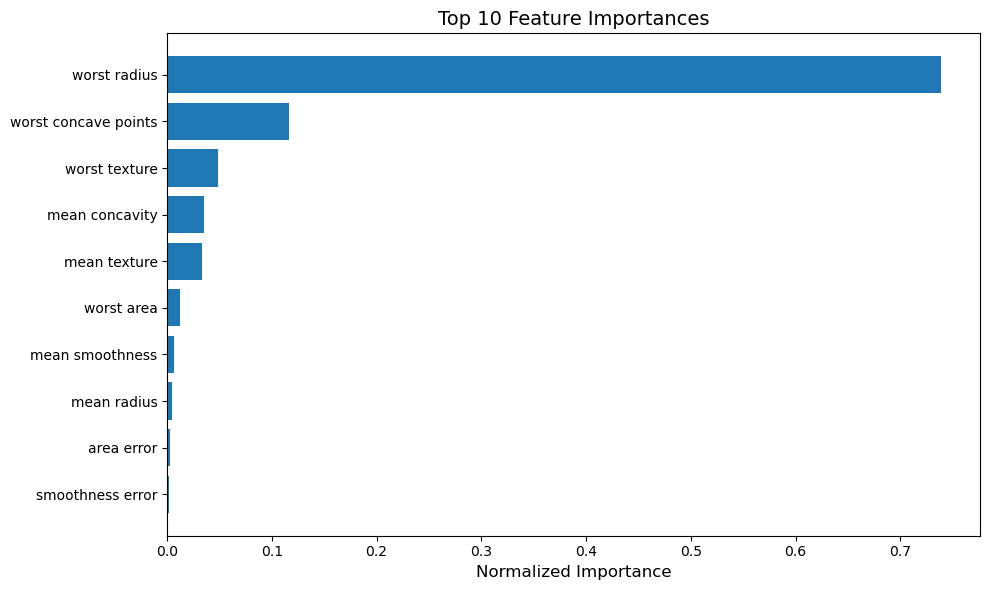


Best max_depth: 3 (Validation Accuracy: 0.9737)


In [19]:

# Main - Run CART on Breast Cancer Dataset

import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier as SklearnDTC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import os

# Create figures directory if it doesn't exist
figures_dir = '../figures'
os.makedirs(figures_dir, exist_ok=True)

# Breast Cancer Wisconsin feature names
FEATURE_NAMES = [
    'mean radius', 'mean texture', 'mean perimeter', 'mean area',
    'mean smoothness', 'mean compactness', 'mean concavity',
    'mean concave points', 'mean symmetry', 'mean fractal dimension',
    'radius error', 'texture error', 'perimeter error', 'area error',
    'smoothness error', 'compactness error', 'concavity error',
    'concave points error', 'symmetry error', 'fractal dimension error',
    'worst radius', 'worst texture', 'worst perimeter', 'worst area',
    'worst smoothness', 'worst compactness', 'worst concavity',
    'worst concave points', 'worst symmetry', 'worst fractal dimension'
]

def load_breast_cancer_data():
    """
    Load and prepare the Breast Cancer Wisconsin dataset.
    
    Reads pre-split training and validation data from CSV files in the ../data/ directory
    and converts them to numpy arrays with appropriate data types.
    
    Returns
    -------
    X_train : ndarray of shape (n_train_samples, n_features)
        Training feature matrix.
    X_val : ndarray of shape (n_val_samples, n_features)
        Validation feature matrix.
    Y_train : ndarray of shape (n_train_samples,)
        Training labels (integers).
    Y_val : ndarray of shape (n_val_samples,)
        Validation labels (integers).
        
    Notes
    -----
    Expected file structure:
        ../data/X_train.csv
        ../data/y_train.csv
        ../data/X_val.csv
        ../data/y_val.csv
    """
    X_train = pd.read_csv('../data/X_train.csv', header=None)
    Y_train = pd.read_csv('../data/y_train.csv', header=None)
    X_val = pd.read_csv('../data/X_val.csv', header=None)
    Y_val = pd.read_csv('../data/y_val.csv', header=None)
    
    Y_train = np.array([i[0] for i in Y_train.values], dtype=int)
    Y_val = np.array([i[0] for i in Y_val.values], dtype=int)
    
    X_train = np.array(X_train)
    X_val = np.array(X_val)
    
    print("Loaded data from data/ directory")
    return X_train, X_val, Y_train, Y_val


def main():
    """
    Main execution function for CART decision tree experiment.
    
    This function performs a comprehensive evaluation of the CART implementation:
    1. Loads the Breast Cancer Wisconsin dataset
    2. Trains our CART implementation and sklearn's implementation
    3. Compares performance metrics between both implementations
    4. Generates detailed classification reports and confusion matrices
    5. Analyzes feature importance
    6. Performs hyperparameter tuning to demonstrate bias-variance trade-off
    7. Creates and saves visualization plots
    
    The experiment demonstrates that our implementation achieves comparable
    performance to sklearn's production-grade implementation.
    """
    print("=" * 70)
    print("CART DECISION TREE CLASSIFIER - BREAST CANCER CLASSIFICATION")
    print("=" * 70)
    
    # Load data
    print("\n### Loading Data ###")
    X_train, X_val, Y_train, Y_val = load_breast_cancer_data()
    
    print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
    print(f"Validation set size: {X_val.shape[0]} samples")
    print(f"Class distribution in training: {np.bincount(Y_train)}")
    
    # Train our CART implementation
    print("\n### Training Our CART Implementation ###")
    our_clf = DecisionTreeClassifier(
        max_depth=5, 
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    our_clf.fit(X_train, Y_train)
    
    # Make predictions
    train_pred = our_clf.predict(X_train)
    val_pred = our_clf.predict(X_val)
    
    # Calculate accuracies
    train_acc = our_clf.score(X_train, Y_train)
    val_acc = our_clf.score(X_val, Y_val)
    
    print(f"\nOur Implementation Results:")
    print(f"  Training Accuracy: {train_acc:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Tree Depth: {our_clf.get_depth()}")
    print(f"  Number of Leaves: {our_clf.get_n_leaves()}")
    
    # Show top of tree structure
    print("\nTree Structure (Top Levels):")
    print("\n".join(str(our_clf).split("\n")[:15]))
    print("... (truncated)")

    # Train sklearn's implementation for comparison
    print("\n### Training sklearn's Implementation ###")
    sk_clf = SklearnDTC(
        max_depth=5,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    sk_clf.fit(X_train, Y_train)
    
    sk_train_pred = sk_clf.predict(X_train)
    sk_val_pred = sk_clf.predict(X_val)
    
    sk_train_acc = sk_clf.score(X_train, Y_train)
    sk_val_acc = sk_clf.score(X_val, Y_val)
    
    print(f"\nsklearn Implementation Results:")
    print(f"  Training Accuracy: {sk_train_acc:.4f}")
    print(f"  Validation Accuracy: {sk_val_acc:.4f}")
    print(f"  Tree Depth: {sk_clf.get_depth()}")
    print(f"  Number of Leaves: {sk_clf.get_n_leaves()}")
    
    # Comparison
    print("\n### Comparison ###")
    print(f"Training Accuracy Difference: {abs(train_acc - sk_train_acc):.6f}")
    print(f"Validation Accuracy Difference: {abs(val_acc - sk_val_acc):.6f}")
    print(f"Tree Depth Difference: {abs(our_clf.get_depth() - sk_clf.get_depth())}")
    
    # Detailed classification report
    print("\n### Detailed Classification Report (Our Implementation) ###")
    print(classification_report(Y_val, val_pred, target_names=['Malignant', 'Benign']))
    
    # Confusion matrix
    print("\n### Confusion Matrix (Our Implementation) ###")
    cm = confusion_matrix(Y_val, val_pred)
    print(cm)
    print("\nConfusion Matrix Interpretation:")
    print(f"  True Negatives (Malignant correctly classified): {cm[0, 0]}")
    print(f"  False Positives (Malignant misclassified as Benign): {cm[0, 1]}")
    print(f"  False Negatives (Benign misclassified as Malignant): {cm[1, 0]}")
    print(f"  True Positives (Benign correctly classified): {cm[1, 1]}")
    
    # Feature Importance
    print("\n### Feature Importance Analysis ###")
    importances = our_clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    print("Top 5 Features (by Gini Importance):")
    for f in range(min(5, X_train.shape[1])):
        print(f"  {FEATURE_NAMES[indices[f]]}: {importances[indices[f]]:.4f}")
        
    # Hyperparameter tuning demonstration
    print("\n### Hyperparameter Tuning & Bias-Variance Trade-off ###")
    print("Testing different max_depth values to visualize overfitting...")
    
    depths = [2, 3, 4, 5, 6, 7, 8, 10]
    train_accs = []
    val_accs = []
    
    for depth in depths:
        clf_temp = DecisionTreeClassifier(max_depth=depth, random_state=42)
        clf_temp.fit(X_train, Y_train)
        train_accs.append(clf_temp.score(X_train, Y_train))
        val_accs.append(clf_temp.score(X_val, Y_val))
        print(f"  max_depth={depth:2d}: Train Acc={train_accs[-1]:.4f}, Val Acc={val_accs[-1]:.4f}")
    
    # Plot 1: Bias-Variance Trade-off
    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_accs, 'o-', label='Training Accuracy', linewidth=2, markersize=8)
    plt.plot(depths, val_accs, 's-', label='Validation Accuracy', linewidth=2, markersize=8)
    plt.xlabel('Maximum Tree Depth', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Bias-Variance Trade-off', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save figure
    bias_variance_path = os.path.join(figures_dir, 'bias_variance_tradeoff.png')
    plt.savefig(bias_variance_path, dpi=300, bbox_inches='tight')
    print(f"\nSaved figure: {bias_variance_path}")
    plt.show()
    
    # Plot 2: Feature Importances (Top 10)
    plt.figure(figsize=(10, 6))
    top_k = 10
    top_indices = indices[:top_k]
    top_importances = importances[top_indices]
    top_names = [FEATURE_NAMES[i] for i in top_indices]
    
    y_pos = np.arange(top_k)
    plt.barh(y_pos, top_importances, align='center')
    plt.yticks(y_pos, top_names, fontsize=10)
    plt.xlabel('Normalized Importance', fontsize=12)
    plt.title(f'Top {top_k} Feature Importances', fontsize=14)
    plt.gca().invert_yaxis()  # Highest importance at top
    plt.tight_layout()
    
    # Save figure
    feature_importance_path = os.path.join(figures_dir, 'feature_importance.png')
    plt.savefig(feature_importance_path, dpi=300, bbox_inches='tight')
    print(f"Saved figure: {feature_importance_path}")
    plt.show()
    
    # Find best depth
    best_depth_idx = np.argmax(val_accs)
    best_depth = depths[best_depth_idx]
    best_val_acc = val_accs[best_depth_idx]
    print(f"\nBest max_depth: {best_depth} (Validation Accuracy: {best_val_acc:.4f})")
    
    print("=" * 70)

np.random.seed(42)

main()


## References

- Breiman, L., Friedman, J.H., Olshen, R.A. and Stone, C.J. (1984) *Classification and Regression Trees*. Wadsworth, Belmont, CA.
- Loh, W.Y. (2011) 'Classification and regression trees', *Wiley Interdisciplinary Reviews: Data Mining and Knowledge Discovery*, 1(1), pp. 14–23.
- Pedregosa, F. *et al.* (2011) 'Scikit-learn: Machine learning in Python', *Journal of Machine Learning Research*, 12, pp. 2825–2830.
- Dua, D. and Graff, C. (2019) 'UCI Machine Learning Repository'. University of California, Irvine, School of Information and Computer Science. Available at: https://archive.ics.uci.edu/ml (Accessed: 6 December 2025).
- Street, W.N., Wolberg, W.H. and Mangasarian, O.L. (1993) 'Nuclear feature extraction for breast tumor diagnosis', *Biomedical Image Processing and Biomedical Visualization*, pp. 861–870.
